**Importing necessary libraries** 

In [135]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

**Loading Data And Preprocessing**

Saving all the paths that we need

In [136]:
token_path = "D:\Image caption generator\Flickr8k_text\Flickr8k.token.txt"
train_images_path = "D:\Image caption generator\Flickr8k_text\Flickr_8k.trainImages.txt"
test_images_path = "D:\Image caption generator\Flickr8k_text\Flickr_8k.testImages.txt"
images_path = "D:\Image caption generator\Flicker8k_Dataset"
glove_path = "D:\Image caption generator\glove.6B"

doc = open(token_path,'r').read()
print(doc[:480])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fightin


Creating a dictionary named descriptions to store the 5 captions for each image

In [137]:
descriptions = dict()
for line in doc.split('\n'):
    tokens = line.split()
    if(len(line)>2):
        image_id = tokens[0].split('.')[0]
        image_desc = " ".join(tokens[1:])
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)         

Removing punctuations and making our descriptions lowercase

In [138]:
table = str.maketrans('','',string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc = " ".join(desc)
        desc_list[i] = desc


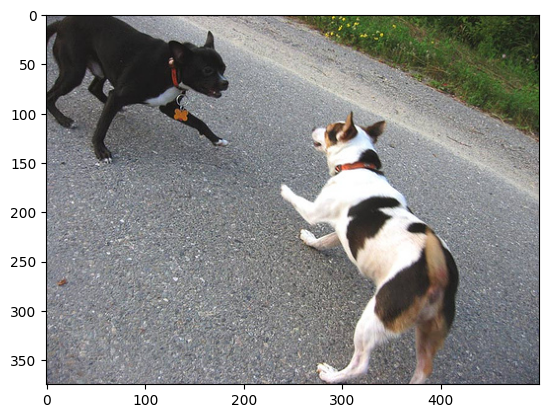

['a black dog and a spotted dog are fighting',
 'a black dog and a tricolored dog playing with each other on the road ',
 'a black dog and a white dog with brown spots are staring at each other in the street ',
 'two dogs of different breeds looking at each other on the road ',
 'two dogs on pavement moving toward each other ']

In [139]:
pic = '1001773457_577c3a7d70.jpg'
x=plt.imread(images_path+ "\\" + pic)
plt.imshow(x)
plt.show()
descriptions['1001773457_577c3a7d70']

Creating vocabulary for the descriptions stored
 

In [140]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))    

Original Vocabulary Size: 8828


Saving the image ids and new cleaned captions in same format as token.txt

In [141]:
lines = list()
for key,desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + " " + desc)

new_descriptions = '\n'.join(lines)

Saving the image id of all 6000 training image ids in a train variable

In [142]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

Saving all the training and testing images in train_img and test_img lists respectively

In [143]:
img = glob.glob(images_path +'\\' + '*.jpg')
train_images = set(open(train_images_path,'r').read().strip().split('\n'))
train_img = []
for i in img:
    if i[len(images_path)+1:] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path)+1:] in test_images: 
        test_img.append(i)        

Loading the descriptions of the training images into a dictionary and adding two tokens in every caption, which are ‘startseq’ and ‘endseq’

In [144]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq' +" " + ' '.join(image_desc) + " "+'endseq'
        train_descriptions[image_id].append(desc)
    

Creating a list of all the training captions

In [145]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

To make our model more robust we will reduce our vocabulary to only those words which occur at least 10 times in the entire corpus

In [146]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


Now we create two dictionaries to map words to an index and vice versa. Also, we append 1 to our vocabulary since we append 0’s to make all captions of equal length.

In [148]:
ixtoword = {}
wordtoix = {}
ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix+=1

vocab_size = len(vocab)+1        

Finding the max length of the captions

In [149]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]

lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)


Description Length: 38


Mapping all the words in our 38-word long caption to a 200-dimension vector using Glove.

In [150]:
embeddings_index = {}
f = open(os.path.join(glove_path,'glove.6B.200d.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs

In [151]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size,embedding_dim))
for word,i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Model Building and Training

In [152]:
model = InceptionV3(weights='imagenet')

Removing the Softmax layer since we need only the feature vector

In [153]:
model_new = Model(model.input, model.layers[-2].output)

Creating a Preprocessing function for our images and encoding them to feature vectors

In [154]:
def preprocess(image_path):
    img = image.load_img(image_path,target_size=(299,299))
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return x

In [155]:
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec,fea_vec.shape[1])
    return fea_vec

encoding_train = {}

for img in train_img:
    encoding_train[img[len(images_path)+1:]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path)+1:]] = encode(img)
test_features = encoding_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━

We are creating a Merge model where we combine the image vector and the partial caption. Therefore our model will have 3 major steps:

1. Processing the sequence from the text
2. Extracting the feature vector from the image
3. Decoding the output using softmax by concatenating the above two layers

In [156]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 38, 200)   │    332,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 38, 200)   │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 38)        │          0 │ input_layer_8[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    467,968 │ dropout_5[0][0],  │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 256)       │          0 │ dense_6[0][0],    │
│                     │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │     65,792 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1660)      │    426,620 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,816,924 (6.93 MB)

 Trainable params: 1,816,924 (6.93 MB)

 Non-trainable params: 0 (0.00 B)

Before training the model we need to keep in mind that we do not want to retrain the weights in our embedding layer (pre-trained Glove vectors)

In [157]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')

Creating a function that can train the data in batches

In [158]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield (np.array(X1), np.array(X2)) ,np.array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [159]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 299s 148ms/step - loss: 4.1575
Epoch 2/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 301s 150ms/step - loss: 3.0894
Epoch 3/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 806s 403ms/step - loss: 2.8541
Epoch 4/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 350s 175ms/step - loss: 2.7248
Epoch 5/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 347s 174ms/step - loss: 2.6335
Epoch 6/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 357s 179ms/step - loss: 2.5652
Epoch 7/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 314s 157ms/step - loss: 2.5138
Epoch 8/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 305s 152ms/step - loss: 2.4702
Epoch 9/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 306s 153ms/step - loss: 2.4333
Epoch 10/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 303s 152ms/step - loss: 2.3992
Epoch 11/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 312s 156ms/step - loss: 2.3736
Epoch 12/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 318s 159ms/step - loss: 2.3499
Epoch 13/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 315s 158ms/step - loss: 2.3297
Epoch 14/30
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 310s

Defining functions for Greedy Search and Beam Search

In [160]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [161]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
    start_word = temp
        # Sorting according to the probabilities
    start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
    start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption                 

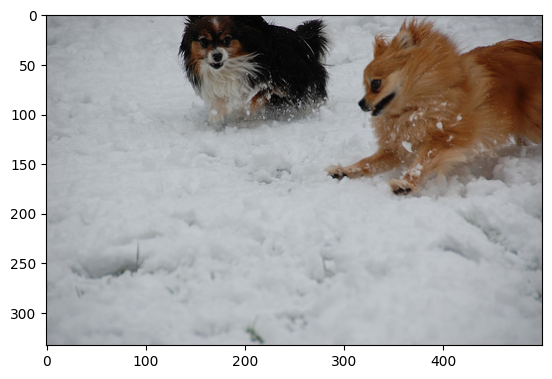

Greedy Search: a dog is running through the snow


In [165]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+ "\\"+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 1))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))


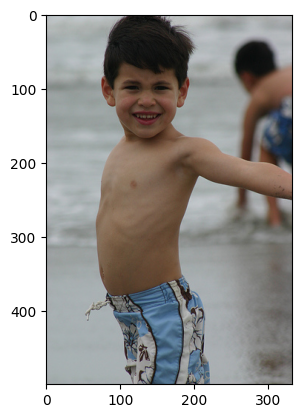

Greedy: a boy in a black swimsuit is running through the water


In [166]:
pic = list(encoding_test.keys())[1]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+ "\\" +pic)
plt.imshow(x)
plt.show()

print("Greedy:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))